This is a notebook on exploratory data analysis on instacart business data

In [72]:
import gc
import time
import numpy as np 
import pandas as pd 
from subprocess import check_output
from util import *
path_data = './'
priors, train, orders, products, aisles, departments, sample_submission = load_data(path_data)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation
pd.set_option('display.float_format', lambda x: '%.3f' % x) #Limiting floats output to 3 decimal points

Obtain the size of order-product data

In [6]:
print "The order_products_train size is : ", train.shape
print "The order_products_prior size is : ", priors.shape

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


Take a glance at this order-product dataframe

In [5]:
train.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


In [11]:
# Check the number of unique orders and unique products
priors_orders_unique = priors.order_id.nunique()
priors_products_unique = priors.product_id.nunique()
print "There are %s orders for %s products for prior data" %(priors_orders_unique, priors_products_unique)
train_orders_unique = train.order_id.nunique()
train_products_unique = train.product_id.nunique()
print "There are %s orders for %s products for train data" %(train_orders_unique, train_products_unique)

There are 3214874 orders for 49677 products for prior data
There are 131209 orders for 39123 products for train data


How many product do people tend to put in their basket each time?

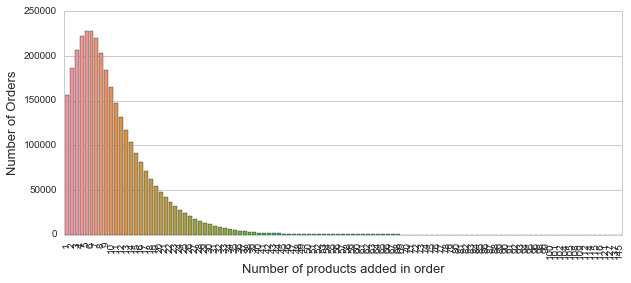

In [41]:
grouped = priors.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(10,4))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

take a glance at orders dataframe

In [37]:
orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,nan
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000


let's see how many orders these people have made:

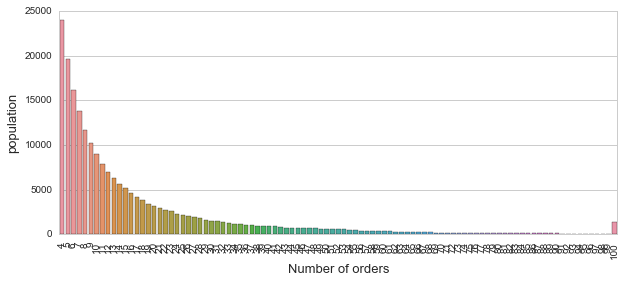

In [40]:
grouped = orders.groupby("user_id")["order_number"].aggregate("max").rename('max_order').reset_index()
grouped = grouped.max_order.value_counts()
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(10, 4))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('population', fontsize=13)
plt.xlabel('Number of orders', fontsize=13)
plt.show()

So everyone makes more than 1 order on this platform.

Now let's see if people like to reorder staffs they are familiar with

In [48]:
grouped = priors.groupby('product_id')['reordered'].mean().reset_index()
grouped = grouped.sort_values('reordered',ascending=False)
grouped.head()

,product_id,reordered
6430,6433,0.941
2074,2075,0.931
43545,43553,0.923
27734,27740,0.921
14605,14609,0.914


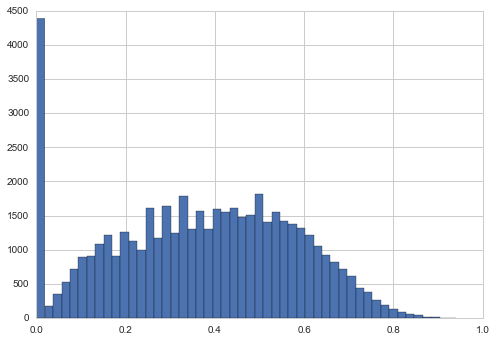

In [52]:
num,bins,_=plt.hist(grouped.reordered,bins=50)

We should check how likely do people tend to buy new staffs in *train* session

In [54]:
priors_detail = priors.merge(orders,how='left',on='order_id')
train_detail = train.merge(orders,how='left',on='order_id')

In [57]:
priors_detail.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.000
1,2,28985,2,1,202279,prior,3,5,9,8.000
2,2,9327,3,0,202279,prior,3,5,9,8.000


In [64]:
prior_up_pairs = priors_detail.groupby(['product_id','user_id'])['order_id'].count().reset_index()
train_up_pairs = train_detail.groupby(['product_id','user_id'])['order_id'].count().reset_index()
train_up_pairs.head(3)

,product_id,user_id,order_id
0,1,751,1
1,1,1540,1
2,1,2221,1


In [68]:
train_up_pairs['up']=train_up_pairs.user_id.apply(str)+'_'+train_up_pairs.product_id.apply(str)
prior_up_pairs['up']=prior_up_pairs.user_id.apply(str)+'_'+prior_up_pairs.product_id.apply(str)

In [70]:
1.0*sum(train_up_pairs['up'].isin(prior_up_pairs['up']))/len(train_up_pairs)

0.5985944127509629

So there are 40% of products in 'train' session that are actually new that were bought by the same person before

This is a bad thing since if we only make prediction based on prior dataset, we might fail to predict 40% of transaction. 

For now we could have a look at this 40% of products

In [76]:
this40products = train_up_pairs[~train_up_pairs['up'].isin(prior_up_pairs['up'])].merge(train,how='left',on='product_id')
this40products.head()

,product_id,user_id,order_id_x,up,order_id_y,add_to_cart_order,reordered
0,1,751,1,751_1,6695,7,1
1,1,751,1,751_1,48361,9,0
2,1,751,1,751_1,63770,4,0
3,1,751,1,751_1,75339,9,0
4,1,751,1,751_1,240996,3,1


In [ ]:
this40products = this40products.drop(['up','order_id_x','order_id_y'],axis=1)